# Main Script Bank Telemarketing Dataset

First required packages and the data is loaded. Note that both the training- and validation dataset as well as the test dataset are taken from the bank-full.csv dataset. A random sampel of 6'000 nodes is taken for both subsets. 

If the dataset would be considered for the results chapter, the dataset would have first been randomly split into two datasets and then subsampled separately. The results do however not differ in any significant way. When sampling from the same dataset, technically identical observations could be present in both training and test dataset. Given the large size of the original datset with over 45'000 observations, this is unlikely to cause a problem or significantly bias the results.

In [1]:
# import all required packages
import time
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
plt.style.use('ggplot')

import networkx as nx
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

import dgl
import dgl.nn as dglnn

import torch
import torch.nn as nn
import torch.nn.functional as F

import tqdm

import sklearn.metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

Using backend: pytorch


In [2]:
df = pd.read_csv('bank-full.csv',sep=';')
df_train_valid = df.sample(n=6000,replace=False)
df_feature_train = df_train_valid.copy(deep=True)
# df_train_valid = pd.read_csv('bank.csv',sep=';')
df_train_valid.reset_index(inplace=True,drop=True)
df_test = df.sample(n=6000,replace=False)
df_test.reset_index(inplace=True,drop=True)

Below the unbalanced label distribution for both datasets is shown

In [3]:
df_train_valid.y.value_counts(normalize=True)

no     0.8765
yes    0.1235
Name: y, dtype: float64

In [4]:
df_test.y.value_counts(normalize=True)

no     0.877667
yes    0.122333
Name: y, dtype: float64

In [5]:
df_train_valid

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,49,management,married,tertiary,no,223,no,no,cellular,28,aug,22,22,-1,0,unknown,no
1,46,blue-collar,married,primary,no,222,no,no,cellular,8,aug,71,2,-1,0,unknown,no
2,35,management,single,tertiary,no,1599,yes,yes,cellular,13,apr,407,1,-1,0,unknown,yes
3,59,retired,married,secondary,no,-471,no,no,cellular,7,aug,86,6,-1,0,unknown,no
4,47,management,married,tertiary,no,2919,yes,no,cellular,17,nov,153,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,66,retired,married,secondary,no,203,no,no,cellular,7,jul,376,1,-1,0,unknown,yes
5996,60,technician,divorced,secondary,no,-50,no,no,cellular,28,aug,433,12,-1,0,unknown,no
5997,50,technician,married,primary,no,-315,no,yes,cellular,8,jul,173,1,-1,0,unknown,no
5998,39,management,married,tertiary,no,-1026,yes,no,unknown,26,may,200,2,-1,0,unknown,no


## The variables are recoded into a useful format

In [6]:
df_train_valid.age = df_train_valid.age.apply(lambda x: 0 if x < 25 else(1 if x < 35 else(2 if x < 50 else(3 if x < 65 else 4))))

#df.job = df.job.apply(lambda x: 0 if x == 'unemployed' else(1 if x == 'services' \
#                            else(2 if x == 'management' else(3 if x == 'blue-collar' \
#                                else(4 if x == 'self-employed' else(5 if x == 'technician' \
#                                    else(6 if x == 'entrepreneur' else(7 if x == 'admin.' \
#                        else(8 if x =='student' else(9 if x == 'housemaid' \
#                            else(10 if x == 'retired' else 11)))))))))))

#df.job = df.job.apply(lambda x: 0 if x == 'unemployed' or 'unknown' else(1 if x == 'services' \
#                        or x == 'management' or x == 'admin.' else(2 if x == 'blue-collar' or x == 'technician' \
#                                    or x == 'housemaid' else(3 if x == 'self-employed' or x == 'entrepreneur' \
#                                        else(4 if x == 'student' else 5)))))

df_train_valid.job = df_train_valid.job.apply(lambda x: 0 if x == 'student' else(2 if x == 'retired' else(3 if x == 'unemployed' or x == 'unknown' else 1)))


df_train_valid.marital = df_train_valid.marital.apply(lambda x: 0 if x == 'single' else(1 if x == 'married' else 2))

df_train_valid.education = df_train_valid.education.apply(lambda x: 0 if x == 'primary' else(1 if x == 'secondary' else(2 if x == 'tertiary' else 3)))

df_train_valid.default = df_train_valid.default.apply(lambda x: 0 if x == 'no' else 1)

df_train_valid.balance = df_train_valid.balance.apply(lambda x: 0 if x < 0 else(1 if x < 69. else(2 if x < 444. else(3 if x < 1480 else 4))))

df_train_valid.housing = df_train_valid.housing.apply(lambda x: 0 if x == 'no' else 1)

df_train_valid.loan = df_train_valid.loan.apply(lambda x: 0 if x == 'no' else 1)

df_train_valid.contact = df_train_valid.contact.apply(lambda x: 0 if x == 'telephone' else(1 if x == 'cellular' else 2))

#df_train_valid.duration = df_train_valid.duration.apply(lambda x: 0 if x < 104. else(1 if x < 185 else(2 if x < 329 else 3)))

df_train_valid.pdays = df_train_valid.pdays.apply(lambda x: 1 if x > 150 or x == -1 else 0)

df_train_valid.poutcome = df_train_valid.poutcome.apply(lambda x: 0 if x == 'failure' else(1 if x == 'success' else 2))

df_train_valid.y = df_train_valid.y.apply(lambda x: 0 if x == 'no' else 1)

df_train_valid.drop(columns = ['day','month'],inplace=True)


In [7]:
df_train_valid

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,y
0,2,1,1,2,0,2,0,0,1,22,22,1,0,2,0
1,2,1,1,0,0,2,0,0,1,71,2,1,0,2,0
2,2,1,0,2,0,4,1,1,1,407,1,1,0,2,1
3,3,2,1,1,0,0,0,0,1,86,6,1,0,2,0
4,2,1,1,2,0,4,1,0,1,153,1,1,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,4,2,1,1,0,2,0,0,1,376,1,1,0,2,1
5996,3,1,2,1,0,0,0,0,1,433,12,1,0,2,0
5997,3,1,1,0,0,0,0,1,1,173,1,1,0,2,0
5998,2,1,1,2,0,0,1,0,2,200,2,1,0,2,0


## The Correlation Matrix of the Dataset

In [8]:
corr = df_train_valid.corr()
corr

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,y
age,1.000000,0.258227,0.394482,-0.115694,0.001196,0.082823,-0.172267,-0.015600,-0.069664,-0.015957,0.019630,0.002256,-0.003435,-0.006054,0.003791
job,0.258227,1.000000,0.108828,-0.090812,0.025305,0.041629,-0.138206,-0.029463,-0.051595,0.027231,-0.013387,-0.008750,-0.014682,0.000292,0.034195
marital,0.394482,0.108828,1.000000,-0.125128,0.033817,-0.010495,0.001455,0.050415,-0.004296,-0.012942,0.018688,0.019570,-0.016341,0.001688,-0.044038
education,-0.115694,-0.090812,-0.125128,1.000000,-0.034903,0.073199,-0.089847,-0.040540,-0.065547,0.002592,0.017191,-0.068879,0.015782,-0.042042,0.089449
default,0.001196,0.025305,0.033817,-0.034903,1.000000,-0.187973,0.011023,0.074418,0.020887,-0.019554,0.027158,0.031316,-0.014485,0.037132,-0.024508
balance,0.082823,0.041629,-0.010495,0.073199,-0.187973,1.000000,-0.066412,-0.126583,-0.070891,0.038064,-0.026619,-0.082606,0.050815,-0.055833,0.107781
housing,-0.172267,-0.138206,0.001455,-0.089847,0.011023,-0.066412,1.000000,0.064957,0.193501,0.002442,-0.021745,0.076477,0.053652,-0.073842,-0.143998
loan,-0.015600,-0.029463,0.050415,-0.040540,0.074418,-0.126583,0.064957,1.000000,0.019838,-0.011892,0.018914,0.028760,-0.023949,0.030030,-0.068304
contact,-0.069664,-0.051595,-0.004296,-0.065547,0.020887,-0.070891,0.193501,0.019838,1.000000,-0.000518,-0.024996,0.123615,-0.154530,0.202199,-0.138585
duration,-0.015957,0.027231,-0.012942,0.002592,-0.019554,0.038064,0.002442,-0.011892,-0.000518,1.000000,-0.083249,-0.004935,-0.005234,0.014267,0.401653


## Duration Attribute

It is investigated, whether the attribute duration should be added as an attribute. This variable has the largest correlation with the label, which why it is considered as a partial substitute for the label. Using duration as an additional attribute unfortunately did not show to improve the classification accuracy. For that reason, the graph shown in the master's thesis including the results correspond to the graph which does not make use of the attribute duration. For simulation purposes, the duration attribute can easily be adding its link-affinity matrix to the link-affinity dictionary used in the MAG model.

In [9]:
df_train_valid.duration.describe()

count    6000.000000
mean      260.257000
std       260.529853
min         2.000000
25%       104.000000
50%       183.000000
75%       318.000000
max      2775.000000
Name: duration, dtype: float64

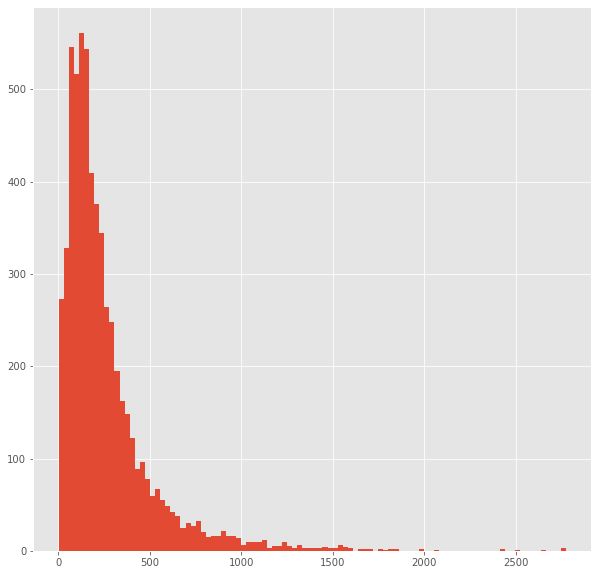

In [10]:
plt.figure(figsize=(10,10))
plt.hist(df_train_valid.duration,bins=100)
#plt.hist(df_train_valid.y,bins=100)
plt.show()

In [11]:
value_comparison = (df_train_valid.duration > 400)

In [12]:
value_comparison

0       False
1       False
2        True
3       False
4       False
        ...  
5995    False
5996     True
5997    False
5998    False
5999    False
Name: duration, Length: 6000, dtype: bool

In [13]:
df_train_valid.y[value_comparison].sum()

377

(array([664.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 377.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

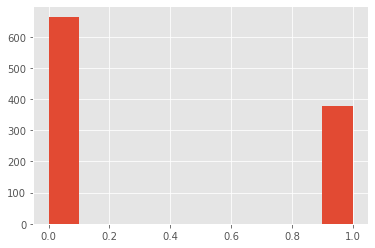

In [14]:
plt.hist(df_train_valid.y[value_comparison==True])

## Attribute Selection

In [15]:
# below, the label y can be included to generate the biased graph
# add y for biased graph
genvars = df_train_valid[['age','job','marital','education','balance','housing']]
#genvars = df_train_valid[['age','job','marital','education','balance','housing','duration']]
genvars.describe()

,age,job,marital,education,balance,housing
count,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000
mean,1.892000,1.108667,0.830000,1.219667,2.415667,0.565333
std,0.805467,0.451544,0.610051,0.748893,1.250259,0.495754
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,1.000000,2.000000,0.000000
50%,2.000000,1.000000,1.000000,1.000000,3.000000,1.000000
75%,2.000000,1.000000,1.000000,2.000000,3.000000,1.000000
max,4.000000,3.000000,2.000000,3.000000,4.000000,1.000000


## Link-affinity matrices

To create the biased graph, add the link-affinity matrix of the label to the affinity matrix dictionary. Further, the label must be added to the matrix containing the attributes

In [16]:
# age
age_alpha0 = 0.90
age_beta1 = 0.80
age_beta2 = 0.60
age_beta3 = 0.40
age_beta4 = 0.20

aff_age = np.array([[age_alpha0,age_beta1,age_beta2,age_beta3,age_beta4],
                    [age_beta1,age_alpha0,age_beta1,age_beta2,age_beta3],
                    [age_beta2,age_beta1,age_alpha0,age_beta1,age_beta2],
                    [age_beta3,age_beta2,age_beta1,age_alpha0,age_beta1],
                    [age_beta4,age_beta3,age_beta2,age_beta1,age_alpha0]])


# job

job_alpha0 = 0.90 # self
job_beta_wf = 0.60 # workforce
job_beta_nwf = 0.60 # not worforce

#aff_job = np.array([[job_alpha0, job_beta_wf , job_beta_wf , job_beta_wf , job_beta_nwf, job_beta_nwf],
#                    [job_beta_nwf, job_alpha0, job_beta_wf, job_beta_wf, job_beta_nwf, job_beta_nwf],
#                    [job_beta_nwf, job_beta_wf, job_alpha0, job_beta_wf, job_beta_nwf, job_beta_nwf],
#                    [job_beta_nwf, job_beta_wf, job_beta_wf, job_alpha0, job_beta_nwf, job_beta_nwf],
#                    [job_beta_nwf, job_beta_wf, job_beta_wf, job_beta_wf, job_alpha0, job_beta_nwf],
#                    [job_beta_nwf, job_beta_wf, job_beta_wf, job_beta_wf, job_beta_nwf, job_alpha0]])

# employment
emp_alpha0 = 0.90 # self
emp_beta_wf = 0.75 # beta workforce / employed / unemployed vs student
emp_beta_ret = 0.70 # beta retired vs workforce
emp_beta_sr = 0.20 # gen gap student / retired

aff_job = np.array([[emp_alpha0,emp_beta_wf,emp_beta_sr,emp_beta_wf],
                    [emp_beta_wf,emp_alpha0,emp_beta_ret,emp_beta_wf],
                    [emp_beta_sr,emp_beta_ret,emp_alpha0,emp_beta_ret],
                    [emp_beta_wf,emp_beta_wf,emp_beta_ret,emp_alpha0]])


# marital

mar_alpha0 = 0.85
mar_beta1 = 0.65

aff_mar = np.array([[mar_alpha0, mar_beta1, mar_beta1],
                    [mar_beta1, mar_alpha0, mar_beta1],
                    [mar_beta1, mar_beta1, mar_alpha0]])

# education
edu_alpha0 = 0.85
edu_beta1 = 0.70
edu_beta2 = 0.55
edu_beta3 = 0.40

aff_edu = np.array([[edu_alpha0,edu_beta1,edu_beta2,edu_beta3],
                    [edu_beta1,edu_alpha0,edu_beta1,edu_beta2],
                    [edu_beta2,edu_beta1,edu_alpha0,edu_beta1],
                    [edu_beta3,edu_beta2,edu_beta1,edu_alpha0]])


# balance
inc_alpha0 = 0.85
inc_beta1 = 0.70
inc_beta2 = 0.60
inc_beta3 = 0.50
inc_beta4 = 0.40
inc_beta5 = 0.25

aff_bal = np.array([[inc_alpha0,inc_beta1,inc_beta2,inc_beta3,inc_beta4],
                    [inc_beta1,inc_alpha0,inc_beta1,inc_beta2,inc_beta3],
                    [inc_beta2,inc_beta1,inc_alpha0,inc_beta1,inc_beta2],
                    [inc_beta3,inc_beta2,inc_beta1,inc_alpha0,inc_beta1],
                    [inc_beta4,inc_beta3,inc_beta2,inc_beta2,inc_alpha0]])

# housing
hous_alpha0 = 0.60
hous_beta1 = 0.40

aff_hous = np.array([[hous_alpha0,hous_beta1],
                     [hous_beta1,hous_alpha0]])


# duration
dur_alpha0 = 0.70
dur_alpha1 = 0.95
dur_beta1 = 0.25

aff_dur = np.array([[dur_alpha0,dur_beta1],
                  [dur_beta1,dur_alpha1]])

# outcome

y_alpha1 = 0.95
y_beta1 = 0.25

aff_y = np.array([[y_alpha1,y_beta1],
                  [y_beta1,y_alpha1]])

aff = {}
aff = {0:aff_age, 1:aff_job ,2:aff_mar ,3:aff_edu ,4:aff_bal ,5:aff_hous}

## MAG Model

In [ ]:
x = genvars.to_numpy()
x = x.astype(int)
x = x.T

P_u_v = np.empty((len(x.T),len(x.T)))
prob_u_v = np.empty((len(x),1))
u = np.empty((len(x),1))
v = np.empty((len(x),1))

# create probability for connection between u and v
for i in range(len(x.T)):
    u = x[:,i]

    for k in range(len(x.T)):
        v = x[:,k]

        for j in range(len(x)):
            aff_current = aff[j]
            prob_u_v[j] = aff_current[u[j],v[j]]

        P_u_v[i,k] = np.prod(prob_u_v) 

In [ ]:
A = np.triu(P_u_v,1)

for i in range(len(P_u_v)):
    for j in range(len(P_u_v)):
        if A[i,j] > np.random.rand():
            A[i,j] = 1
        else:
            A[i,j] = 0


In [ ]:
A = A + A.T
np.sum(A) / 2

## Create and Plot the Graph

In [ ]:
G = nx.from_numpy_matrix(A)

In [ ]:
nx.is_connected(G)

In [ ]:
# nx.draw(G,node_size=20)

In [ ]:
features = pd.Series(df_train_valid.y)

In [ ]:
df_train_valid.drop(columns=['y'],inplace=True)

In [ ]:
not_invest = features.index[features == 0].tolist()
invest = features.index[features == 1].tolist()

In [ ]:
pos = nx.spring_layout(G)

In [ ]:
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G,pos,nodelist=not_invest,node_size=20,node_color='b',label='Did not Invest')
nx.draw_networkx_nodes(G,pos,nodelist=invest,node_size=20,node_color='r',label='Did Invest')
nx.draw_networkx_edges(G,pos)

plt.legend()
plt.show()

## Prepare the Data for GNNs

In [ ]:
df.columns

In [ ]:
df_train_valid

In [ ]:
df_feature_train.reset_index(inplace=True,drop=True)
df_train_valid.age = df_feature_train.age
df_train_valid.balance = df_feature_train.balance
#df_train_valid.drop(columns = ['day','month'],inplace=True)
df_train_valid.duration = df_feature_train.duration


In [ ]:
#df_train_valid.drop(columns = ['pdays'],inplace=True)
#df_train_valid.previous = df_feature_train.previous
df_train_valid.describe()

In [ ]:
def norm(x):
    return F.normalize(x, p=2, dim=-1)

Norm = norm

## Prepare the dgl data and assign features and label

In [ ]:
G_dgl = dgl.from_networkx(G)
feat = df_train_valid.copy(deep=True)
#feat = pd.get_dummies(feat)
scale = StandardScaler()
feat = pd.DataFrame(scale.fit_transform(feat))

G_dgl.ndata['feat'] =  torch.tensor(feat.values,dtype=torch.float)
G_dgl.ndata['train_mask'] = torch.zeros(len(G_dgl.nodes()), dtype=torch.bool).bernoulli(0.8)
G_dgl.ndata['label'] = torch.tensor(features)

In [ ]:
G_dgl.ndata['val_mask'] = torch.empty(len(G_dgl.nodes()))
for i in range(len(G_dgl.ndata['train_mask'])):
    if G_dgl.ndata['train_mask'][i] == True:
        G_dgl.ndata['val_mask'][i] = False
    else:
        G_dgl.ndata['val_mask'][i] = True

G_dgl.ndata['val_mask'] = G_dgl.ndata['val_mask'].type(torch.bool)

In [ ]:
node_features = G_dgl.ndata['feat']
node_labels = G_dgl.ndata['label']
train_mask = G_dgl.ndata['train_mask']
valid_mask = G_dgl.ndata['val_mask']
n_features = node_features.shape[1]
n_labels = int(node_labels.max().item() + 1)

In [ ]:
train_nodes = (train_mask == True).nonzero(as_tuple=False)
train_nids = torch.reshape(train_nodes,(-1,))
valid_nodes = (valid_mask == True).nonzero(as_tuple=False)
valid_nids = torch.reshape(valid_nodes,(-1,))

## Define Dataloaders for minibatch training

In [ ]:

batch_size = 50
#sampler = dgl.dataloading.MultiLayerNeighborSampler([4, 4, 4])
sampler = dgl.dataloading.MultiLayerNeighborSampler([5, 10])
#sampler = dgl.dataloading.MultiLayerNeighborSampler([None])
train_dataloader = dgl.dataloading.NodeDataLoader(
    G_dgl, train_nids, sampler,
    batch_size=batch_size,
    shuffle=True,
    drop_last=False,
    num_workers=0
)

In [ ]:
batch_size = len(valid_nids)
valid_dataloader = dgl.dataloading.NodeDataLoader(
    G_dgl, valid_nids, sampler,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=0
)

In [ ]:
print(len(train_nids))
print(len(valid_nids))
print(len(G.nodes()))

## Define GraphSage Model

In [ ]:
class SAGE(nn.Module):
    def __init__(self, in_feats, n_hidden, n_classes, n_layers,agg_type='pool'):
        super().__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.n_classes = n_classes
        self.layers = nn.ModuleList()
        self.layers.append(dglnn.SAGEConv(in_feats, n_hidden, aggregator_type=agg_type, bias=True, feat_drop=0.02,norm=Norm,activation=nn.ReLU(inplace=False)))
        for i in range(1, n_layers - 1):
            self.layers.append(dglnn.SAGEConv(n_hidden, n_hidden, aggregator_type=agg_type, bias=True, feat_drop=0.02,norm=Norm,activation=nn.ReLU(inplace=False)))
        self.layers.append(dglnn.SAGEConv(n_hidden, n_classes, aggregator_type=agg_type, bias=True, feat_drop=0.02,norm=None,activation=None))
        
    def forward(self, bipartites, x):
        for l, (layer, bipartite) in enumerate(zip(self.layers, bipartites)):
            x = layer(bipartite, x)
        return x

## Train GraphSage and get Results

In [ ]:
model = SAGE(n_features, 124, n_labels, 2) #n_layers
opt = torch.optim.Adam(model.parameters())

In [ ]:
# GraphSage
best_accuracy = 0
best_model_path = 'model.pt'
epoch_losses_train = []
plot_loss_valid = []
train_acc = []
valid_acc = []
dur = []

for epoch in range(400):
    t0 = time.time()
    model.train()
    loss_epoch = 0
    accuracy_epoch = 0
    for step, (input_nodes, output_nodes, bipartites) in enumerate(train_dataloader):
        inputs = node_features[input_nodes]
        labels = node_labels[output_nodes]
        logits = model(bipartites, inputs)
        predictions = F.log_softmax(logits,dim=1)

        loss = F.cross_entropy(logits, labels)
        loss_epoch += loss.detach().item()
        opt.zero_grad()
        loss.backward()
        opt.step()

        accuracy = accuracy_score(labels.numpy(), predictions.argmax(1).detach().numpy())
        accuracy_epoch += accuracy
    accuracy_epoch /= (step + 1)
    loss_epoch /= (step + 1)
    epoch_losses_train.append(loss_epoch)
    train_acc.append(accuracy_epoch)
    print('Epoch: {}, Training Accuracy: {:.3f}, Training Loss: {:.3f}'.format(epoch, accuracy_epoch, loss_epoch))
        
    model.eval()
    
    predictions = []
    labels = []
    with torch.no_grad():
        for input_nodes, output_nodes, bipartites in valid_dataloader:
            inputs = node_features[input_nodes]
            labels.append(node_labels[output_nodes].numpy())
            predictions.append(F.log_softmax(model(bipartites, inputs),dim=1).argmax(1).numpy())
            valid_logits = model(bipartites, inputs)
            valid_labels = node_labels[output_nodes]
            valid_loss = F.cross_entropy(valid_logits, valid_labels)

        predictions = np.concatenate(predictions)
        labels = np.concatenate(labels)
        
        accuracy = accuracy_score(labels, predictions)
        dur.append(time.time() - t0)
        print('Epoch: {}, Validation Accuracy: {:.3f}, Validation Loss: {:.3f}, Time: {:.4f}'.format(epoch, accuracy, valid_loss.item(), np.mean(dur)))
        valid_acc.append(accuracy.item())
        plot_loss_valid.append(valid_loss.item())
    
torch.save(model.state_dict(), best_model_path)

In [ ]:
plt.plot(epoch_losses_train, label='Training Loss')
plt.plot(plot_loss_valid, label='Validation Loss')
plt.legend()
plt.show()

In [ ]:
plt.plot(train_acc, label='Training Accuracy')
plt.plot(valid_acc, label='Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
len(predictions)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

print('Classification Accuracy validation set {}'.format(accuracy_score(valid_labels,predictions)))
print('-------------------------------------------------------------')
print('Confusion Matrix validation set:')
print(confusion_matrix(valid_labels, predictions))

In [ ]:
best_accuracy

In [ ]:
model.parameters

In [ ]:
from sklearn.metrics import roc_auc_score, plot_roc_curve

roc_auc_score(valid_labels,predictions)
#plot_roc_curve(logits, X_test, y_test) 

## Standard Machine Learning Results

### ANN

In [ ]:
from sklearn.model_selection import train_test_split
f =  pd.get_dummies(features)
#x = df.drop(columns='y')
x_train, x_test, y_train, y_test = train_test_split(feat,f, test_size = 0.2, shuffle=True)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
x_train_tf = tf.convert_to_tensor(x_train)
x_test_tf = tf.convert_to_tensor(x_test)
y_train_tf = tf.convert_to_tensor(y_train)
y_test_tf = tf.convert_to_tensor(y_test)

model_ann = Sequential()

model_ann.add(Dense(15, activation='relu'))
#model_ann.add(Dense(8, activation='relu'))
model_ann.add(Dense(2, activation='softmax'))
#opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

model_ann.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model_ann.fit(x_train_tf, y_train_tf,validation_data=(x_test_tf,y_test_tf), epochs=50, batch_size=10)

In [ ]:
plt.plot(history.history['loss'],label = 'Training Loss', color = 'blue')
plt.plot(history.history['val_loss'],label = 'Validation Loss', color = 'red')
plt.xlabel('Number of Epochs')
plt.ylabel('Binary Cross-Entropy Loss')
plt.title('Loss per Epoch')
plt.legend()
plt.show()

In [ ]:
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Support Vector Machine

In [ ]:
from sklearn import svm

svm_y = np.empty((len(features),1))

for i in range(len(features)):
    if features.iloc[i] == 1:
        svm_y[i] = 1
    else:
        svm_y[i] = -1

svm_y.astype(int)
x_train, x_test, y_train, y_test = train_test_split(feat,svm_y, test_size = 0.6, shuffle=True)


clf = svm.SVC()
clf.fit(x_train, y_train)
print('Training Accuracy: ',clf.score(x_train, y_train))
print('Validation Accuracy: ',clf.score(x_test, y_test))

### Random Forest Classifier

In [ ]:
clf = RandomForestClassifier(max_depth=None, random_state=0)

clf.fit(x_train, y_train)
print('Training Accuracy: ',clf.score(x_train, y_train))
print('Validation Accuracy: ',clf.score(x_test, y_test))

##  Generate the Test Graph and prepare Test Dataset

In [ ]:
df_test.age = df_test.age.apply(lambda x: 0 if x < 25 else(1 if x < 35 else(2 if x < 50 else(3 if x < 65 else 4))))

#df.job = df.job.apply(lambda x: 0 if x == 'unemployed' else(1 if x == 'services' \
#                            else(2 if x == 'management' else(3 if x == 'blue-collar' \
#                                else(4 if x == 'self-employed' else(5 if x == 'technician' \
#                                    else(6 if x == 'entrepreneur' else(7 if x == 'admin.' \
#                        else(8 if x =='student' else(9 if x == 'housemaid' \
#                            else(10 if x == 'retired' else 11)))))))))))

#df.job = df.job.apply(lambda x: 0 if x == 'unemployed' or 'unknown' else(1 if x == 'services' \
#                        or x == 'management' or x == 'admin.' else(2 if x == 'blue-collar' or x == 'technician' \
#                                    or x == 'housemaid' else(3 if x == 'self-employed' or x == 'entrepreneur' \
#                                        else(4 if x == 'student' else 5)))))

df_test.job = df_test.job.apply(lambda x: 0 if x == 'student' else(2 if x == 'retired' else(3 if x == 'unemployed' or x == 'unknown' else 1)))


df_test.marital = df_test.marital.apply(lambda x: 0 if x == 'single' else(1 if x == 'married' else 2))

df_test.education = df_test.education.apply(lambda x: 0 if x == 'primary' else(1 if x == 'secondary' else(2 if x == 'tertiary' else 3)))

df_test.default = df_test.default.apply(lambda x: 0 if x == 'no' else 1)

df_test.balance = df_test.balance.apply(lambda x: 0 if x < 0 else(1 if x < 69. else(2 if x < 444. else(3 if x < 1480 else 4))))

df_test.housing = df_test.housing.apply(lambda x: 0 if x == 'no' else 1)

df_test.loan = df_test.loan.apply(lambda x: 0 if x == 'no' else 1)

df_test.contact = df_test.contact.apply(lambda x: 0 if x == 'telephone' else(1 if x == 'cellular' else 2))

df_test.duration = df_test.duration.apply(lambda x: 0 if x < 104. else(1 if x < 185 else(2 if x < 329 else 3)))

df_test.pdays = df_test.pdays.apply(lambda x: 1 if x > 150 or x == -1 else 0)

df_test.poutcome = df_test.poutcome.apply(lambda x: 0 if x == 'failure' else(1 if x == 'success' else 2))

df_test.y = df_test.y.apply(lambda x: 0 if x == 'no' else 1)

df_test.drop(columns = ['day','month'],inplace=True)


In [ ]:
genvars = df_test[['age','job','marital','education','balance','housing']] # add y for biased graph
genvars

In [ ]:
# age
age_alpha0 = 0.90
age_beta1 = 0.80
age_beta2 = 0.60
age_beta3 = 0.40
age_beta4 = 0.20

aff_age = np.array([[age_alpha0,age_beta1,age_beta2,age_beta3,age_beta4],
                    [age_beta1,age_alpha0,age_beta1,age_beta2,age_beta3],
                    [age_beta2,age_beta1,age_alpha0,age_beta1,age_beta2],
                    [age_beta3,age_beta2,age_beta1,age_alpha0,age_beta1],
                    [age_beta4,age_beta3,age_beta2,age_beta1,age_alpha0]])


# job

job_alpha0 = 0.90 # self
job_beta_wf = 0.60 # workforce
job_beta_nwf = 0.60 # not worforce

#aff_job = np.array([[job_alpha0, job_beta_wf , job_beta_wf , job_beta_wf , job_beta_nwf, job_beta_nwf],
#                    [job_beta_nwf, job_alpha0, job_beta_wf, job_beta_wf, job_beta_nwf, job_beta_nwf],
#                    [job_beta_nwf, job_beta_wf, job_alpha0, job_beta_wf, job_beta_nwf, job_beta_nwf],
#                    [job_beta_nwf, job_beta_wf, job_beta_wf, job_alpha0, job_beta_nwf, job_beta_nwf],
#                    [job_beta_nwf, job_beta_wf, job_beta_wf, job_beta_wf, job_alpha0, job_beta_nwf],
#                    [job_beta_nwf, job_beta_wf, job_beta_wf, job_beta_wf, job_beta_nwf, job_alpha0]])

# employment
emp_alpha0 = 0.90 # self
emp_beta_wf = 0.75 # beta workforce / employed / unemployed vs student
emp_beta_ret = 0.70 # beta retired vs workforce
emp_beta_sr = 0.20 # gen gap student / retired

aff_job = np.array([[emp_alpha0,emp_beta_wf,emp_beta_sr,emp_beta_wf],
                    [emp_beta_wf,emp_alpha0,emp_beta_ret,emp_beta_wf],
                    [emp_beta_sr,emp_beta_ret,emp_alpha0,emp_beta_ret],
                    [emp_beta_wf,emp_beta_wf,emp_beta_ret,emp_alpha0]])


# marital

mar_alpha0 = 0.85
mar_beta1 = 0.65

aff_mar = np.array([[mar_alpha0, mar_beta1, mar_beta1],
                    [mar_beta1, mar_alpha0, mar_beta1],
                    [mar_beta1, mar_beta1, mar_alpha0]])

# education
edu_alpha0 = 0.85
edu_beta1 = 0.70
edu_beta2 = 0.55
edu_beta3 = 0.40

aff_edu = np.array([[edu_alpha0,edu_beta1,edu_beta2,edu_beta3],
                    [edu_beta1,edu_alpha0,edu_beta1,edu_beta2],
                    [edu_beta2,edu_beta1,edu_alpha0,edu_beta1],
                    [edu_beta3,edu_beta2,edu_beta1,edu_alpha0]])


# balance
inc_alpha0 = 0.85
inc_beta1 = 0.70
inc_beta2 = 0.60
inc_beta3 = 0.50
inc_beta4 = 0.40
inc_beta5 = 0.25

aff_bal = np.array([[inc_alpha0,inc_beta1,inc_beta2,inc_beta3,inc_beta4],
                    [inc_beta1,inc_alpha0,inc_beta1,inc_beta2,inc_beta3],
                    [inc_beta2,inc_beta1,inc_alpha0,inc_beta1,inc_beta2],
                    [inc_beta3,inc_beta2,inc_beta1,inc_alpha0,inc_beta1],
                    [inc_beta4,inc_beta3,inc_beta2,inc_beta2,inc_alpha0]])

# housing
hous_alpha0 = 0.60
hous_beta1 = 0.40

aff_hous = np.array([[hous_alpha0,hous_beta1],
                     [hous_beta1,hous_alpha0]])

# outcome

y_alpha0 = 0.95
y_beta1 = 0.25

aff_y = np.array([[y_alpha0,y_beta1],
                  [y_beta1,y_alpha0]])

aff = {}
aff = {0:aff_age, 1:aff_job ,2:aff_mar ,3:aff_edu ,4:aff_bal ,5:aff_hous}

In [ ]:
x = genvars.to_numpy()
x = x.astype(int)
x = x.T

P_u_v = np.empty((len(x.T),len(x.T)))
prob_u_v = np.empty((len(x),1))
u = np.empty((len(x),1))
v = np.empty((len(x),1))

# create probability for connection between u and v
for i in range(len(x.T)):
    u = x[:,i]

    for k in range(len(x.T)):
        v = x[:,k]

        for j in range(len(x)):
            aff_current = aff[j]
            prob_u_v[j] = aff_current[u[j],v[j]]

        P_u_v[i,k] = np.prod(prob_u_v) 

In [ ]:
A = np.triu(P_u_v,1)

for i in range(len(P_u_v)):
    for j in range(len(P_u_v)):
        if A[i,j] > np.random.rand():
            A[i,j] = 1
        else:
            A[i,j] = 0


In [ ]:
A = A + A.T
np.sum(A) / 2

In [ ]:
G_test = nx.from_numpy_matrix(A)

In [ ]:
test_features = pd.Series(df_test.y)

## Add Test Data to dgl Graph

In [ ]:
G_dgl_test = dgl.from_networkx(G_test)
feat_test = df_test.drop(columns=['y'])
#feat_test = pd.get_dummies(feat_test)
scale = StandardScaler()
feat_test = pd.DataFrame(scale.fit_transform(feat_test))

embedding_test = torch.tensor(feat_test.values,dtype=torch.float)

G_dgl_test.ndata['feat'] =  embedding_test
#G_dgl.ndata['train_mask'] = torch.zeros(len(G_dgl.nodes()), dtype=torch.bool).bernoulli(0.2)
G_dgl_test.ndata['label'] = torch.tensor(test_features)

In [ ]:
node_features = G_dgl_test.ndata['feat']
node_labels = G_dgl_test.ndata['label']
test_nids = G_dgl_test.nodes()
n_features = node_features.shape[1]
n_labels = int(node_labels.max().item() + 1)

## Define Inference Function

In [ ]:
def inference(model, graph, input_features, batch_size):
    nodes = torch.arange(graph.number_of_nodes())
    
    sampler = dgl.dataloading.MultiLayerNeighborSampler([None])  # one layer at a time, taking all neighbors
    dataloader = dgl.dataloading.NodeDataLoader(
        graph, nodes, sampler,
        batch_size=batch_size,
        shuffle=False,
        drop_last=False,
        num_workers=0)
    
    with torch.no_grad():
        for l, layer in enumerate(model.layers):
            # Allocate a buffer of output representations for every node
            # Note that the buffer is on CPU memory.
            output_features = torch.zeros(
                graph.number_of_nodes(), model.n_hidden if l != model.n_layers - 1 else model.n_classes)

            for input_nodes, output_nodes, bipartites in tqdm.tqdm(dataloader):
                bipartite = bipartites[0].to(torch.device('cpu'))

                x = input_features[input_nodes]

                # the following code is identical to the loop body in model.forward()
                x = layer(bipartite, x)
                if l != model.n_layers - 1:
                    x = F.relu(x)
                    
                elif l == model.n_layers - 1:
                    x = F.log_softmax(x,dim=1)

                output_features[output_nodes] = x.cpu()
            input_features = output_features
    return output_features

## Load trained GraphSage model parameters and get Test results

In [ ]:
model.load_state_dict(torch.load('model.pt'))
all_predictions = inference(model, G_dgl_test, node_features, 6000)

In [ ]:
test_predictions = all_predictions[test_nids].argmax(1)
test_labels = node_labels[test_nids]
test_accuracy = sklearn.metrics.accuracy_score(test_predictions.numpy(), test_labels.numpy())
print('Test accuracy:', test_accuracy)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

print('Classification Accuracy test set {}'.format(accuracy_score(test_labels.numpy(),test_predictions.numpy())))
print('-------------------------------------------------------------')
print('Confusion Matrix test set:')
print(confusion_matrix(test_labels.numpy(),test_predictions.numpy()))